# Udacity Machine Learning Engineer Nanodegree
## Capstone Project: 
## Predicting the Daily Direction of the S&P500

### Completed and Submitted by Stephen Fox
### October 2016


In [1]:
# Import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from time import time
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import re
from IPython.display import display

# Read data from SP500_historical.csv - data contains returns for the S&P500 and VIX index going back over 23 years
# Source: Yahoo Finance

all_data = pd.read_csv("SP500_historical.csv",header=0)
print ("Market data read successfully!")
print ("Number of data points:", len(all_data))

Market data read successfully!
('Number of data points:', 5962)


In [2]:
# Print the column headers
print (all_data.dtypes.index)

Index([u'Date', u'SP_Open', u'SP_High', u'SP_Low', u'SP_Close', u'SP_Volume',
       u'Vix_Open', u'Vix_High', u'Vix_Low', u'Vix_Close'],
      dtype='object')


In [3]:
# Convert the 'Date' column data from a string into a form that can be manipulated mathematically
# Calculate the 'Days_Since_Open' feature, which is a measure of how many days have passed since the market last opened

from datetime import datetime

all_data['Date'] = pd.to_datetime(all_data['Date'])

all_data['Days_Since_Open'] = (all_data['Date'] - all_data['Date'].shift(-1))
all_data['Days_Since_Open'] = all_data['Days_Since_Open'].astype('timedelta64[D]')

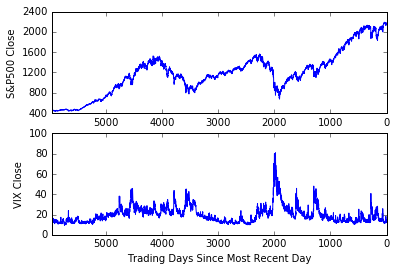

In [4]:
# Visualize some of the key data

%matplotlib inline

import matplotlib.pyplot as plt

plot_data = all_data.SP_Close
plot_data_VIX = all_data.Vix_Close


f, axes = plt.subplots(2, 1)

axes[0].axis([5962,0,400,2200])
axes[0].plot(plot_data)
axes[0].set_ylabel('S&P500 Close')
axes[0].set_yticks([400,800,1200,1600,2000,2400])

axes[1].axis([5962,0,0,100])
axes[1].plot(plot_data_VIX)
axes[1].set_ylabel('VIX Close')
plt.xlabel('Trading Days Since Most Recent Day')

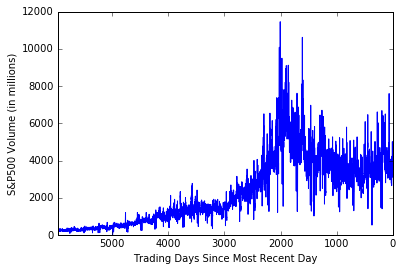

In [5]:
plot_data_Volume = all_data.SP_Volume / 1000000

plt.axis([5962,0,14,12000])
plt.plot(plot_data_Volume)
plt.ylabel('S&P500 Volume (in millions)')
plt.xlabel('Trading Days Since Most Recent Day')

In [6]:
# Calculate the 'Break_Coming' feature, which is a measure of whether the market will close for a break on the next day

all_data['Break_Coming'] = all_data['Days_Since_Open'].shift(1)

all_data.loc[all_data['Break_Coming']<=1,'Break_Coming'] = 0
all_data.loc[all_data['Break_Coming']>1,'Break_Coming'] = 1

all_data.Break_Coming.fillna(0, inplace=True)

In [7]:
# Calculate the 'Overnight_Return' feature

all_data['Overnight_Return'] = all_data['SP_Open'] / all_data['SP_Close'].shift(-1) - 1

In [8]:
# Calculate the 'No_Overnight_Change' value. This is not a feature, but was used to identify unreliable data rows
# See accompanying report for further details

all_data['No_Overnight_Change'] = all_data['Overnight_Return']

all_data.loc[all_data['No_Overnight_Change']==0.00,'No_Overnight_Change'] = 1
all_data.loc[all_data['No_Overnight_Change']!=1,'No_Overnight_Change'] = 0

In [9]:
# Calculate the 'Overnight_VIX' feature, which measures whether the VIX has opened up or down relative to previous day

all_data['Overnight_VIX'] = all_data['Vix_Open'] / all_data['Vix_Close'].shift(-1) - 1

In [10]:
# Calculate the 'O_to_O' feature, which compares the current opening price to the previous day

all_data['O_to_O'] = all_data['SP_Open'] / all_data['SP_Open'].shift(-1) - 1

In [11]:
# Calculate 11 different trailing return features, 9 based on the S&P500 data and 2 based on VIX data

all_data['Trail_1d_Ret'] = all_data['SP_Close'].shift(-1) / all_data['SP_Close'].shift(-2) - 1
all_data['Trail_2d_Ret'] = all_data['SP_Close'].shift(-1) / all_data['SP_Close'].shift(-3) - 1
all_data['Trail_3d_Ret'] = all_data['SP_Close'].shift(-1) / all_data['SP_Close'].shift(-4) - 1
all_data['Trail_4d_Ret'] = all_data['SP_Close'].shift(-1) / all_data['SP_Close'].shift(-5) - 1
all_data['Trail_5d_Ret'] = all_data['SP_Close'].shift(-1) / all_data['SP_Close'].shift(-6) - 1
all_data['Trail_21d_Ret'] = all_data['SP_Close'].shift(-1) / all_data['SP_Close'].shift(-22) - 1
all_data['Trail_63d_Ret'] = all_data['SP_Close'].shift(-1) / all_data['SP_Close'].shift(-64) - 1
all_data['Trail_126d_Ret'] = all_data['SP_Close'].shift(-1) / all_data['SP_Close'].shift(-127) - 1
all_data['Trail_252d_Ret'] = all_data['SP_Close'].shift(-1) / all_data['SP_Close'].shift(-253) - 1

all_data['Trail_1d_VIX'] = all_data['Vix_Close'].shift(-1) / all_data['Vix_Close'].shift(-2) - 1
all_data['Trail_5d_VIX'] = all_data['Vix_Close'].shift(-1) / all_data['Vix_Close'].shift(-6) - 1

In [12]:
# Calculate 2 different trailing volume features, which measure whether the last day's volume is above or below
# recent averages

all_data['Trail_1d_Rel_Vol'] = all_data['SP_Volume'].shift(-1) / (
    all_data['SP_Volume'].rolling(window=4).mean().shift(-5)) - 1

all_data['Trail_5d_Rel_Vol'] = all_data['SP_Volume'].rolling(window=5).mean().shift(-5) / (
    all_data['SP_Volume'].rolling(window=21).mean().shift(-26)) - 1

In [13]:
# Calculate the 'Trail_1d_PtT' feature, which measure how much the S&P500 moved from high to low values on the 
# previous trading day

all_data['Trail_1d_PtT'] = (all_data['SP_High'].shift(-1) - all_data['SP_Low'].shift(-1)) / (0.5*(
        all_data['SP_Open'].shift(-1) + all_data['SP_Close'].shift(-1)))

In [14]:
# Calculate the 'Trail_1d_VIX_PtT' feature, which measure how much the VIX moved from high to low values on the 
# previous trading day

all_data['Trail_1d_VIX_PtT'] = (all_data['Vix_High'].shift(-1) - all_data['Vix_Low'].shift(-1)) / (0.5*(
        all_data['Vix_Open'].shift(-1) + all_data['Vix_Close'].shift(-1)))

In [15]:
# Calculate the 'Intraday_Increase' label, which is ultimately what the machine learner should predict, and as is a
# measure of whether the S&P500 increased on a given day (value = 1) or not (value = 0)

all_data['Intraday_Increase'] = all_data['SP_Close'] - all_data['SP_Open']

all_data.loc[all_data['Intraday_Increase']>0,'Intraday_Increase'] = 1
all_data.loc[all_data['Intraday_Increase']<=0,'Intraday_Increase'] = 0

I am now going to delete those rows that have N/A values (e.g. you cannot do a 252 day trailing return if there are fewer than 252 days trailing a given data point)

In [16]:
noNA_data = all_data.dropna()

print ("Number of data points:", len(noNA_data))

('Number of data points:', 5709)


I will also delete rows where 'No_Overnight_Change' is equal to 1. These are points where the opening value is IDENTICAL to the previous closing data, which likely reflects missing true opening prices (the chances of the market opening at the identical level as the previous close are slim to none). Most of these points came from the older portion of the data set. There were almost no points like this in the most recent 10 years:

In [17]:
validated_data = noNA_data[noNA_data.No_Overnight_Change != 1]
print ("Number of data points:", len(validated_data))

('Number of data points:', 2678)


Next, I need to drop columns that would allow the machine learning algorithm to 'know the future'. For example, it cannot be trained using SP_Close for any given day, since that would trivially allow it to calculate whether the market closed up on any given day. It can only be provided information that one would know at the start of the day (i.e. data from previous days and the opening data). This rules out High, Low and Close values for the market and the VIX and also the market volume for any given day. Finally, I will limit the analysis to relative returns, not absolute values of the indeces, given that the stock market tends to increase with time and hence comparing the absolute value of the S&P500 over a 20+ year period will not be helpful. 

In summary, the final data set will consist of only the 20 calculated features and the 1 label, for the 2,678 validated data rows.

In [18]:
# Print the column headers of the current data set
print (validated_data.dtypes.index)

Index([u'Date', u'SP_Open', u'SP_High', u'SP_Low', u'SP_Close', u'SP_Volume',
       u'Vix_Open', u'Vix_High', u'Vix_Low', u'Vix_Close', u'Days_Since_Open',
       u'Break_Coming', u'Overnight_Return', u'No_Overnight_Change',
       u'Overnight_VIX', u'O_to_O', u'Trail_1d_Ret', u'Trail_2d_Ret',
       u'Trail_3d_Ret', u'Trail_4d_Ret', u'Trail_5d_Ret', u'Trail_21d_Ret',
       u'Trail_63d_Ret', u'Trail_126d_Ret', u'Trail_252d_Ret', u'Trail_1d_VIX',
       u'Trail_5d_VIX', u'Trail_1d_Rel_Vol', u'Trail_5d_Rel_Vol',
       u'Trail_1d_PtT', u'Trail_1d_VIX_PtT', u'Intraday_Increase'],
      dtype='object')


In [19]:
# Drop the columns that are not one of the 20 features or the label
data = validated_data.drop(validated_data.columns[[0,1,2,3,4,5,6,7,8,9,13]], axis=1)

In [20]:
# Print the headers of 'data', to validate that the correct columns were dropped
print (data.dtypes.index)

Index([u'Days_Since_Open', u'Break_Coming', u'Overnight_Return',
       u'Overnight_VIX', u'O_to_O', u'Trail_1d_Ret', u'Trail_2d_Ret',
       u'Trail_3d_Ret', u'Trail_4d_Ret', u'Trail_5d_Ret', u'Trail_21d_Ret',
       u'Trail_63d_Ret', u'Trail_126d_Ret', u'Trail_252d_Ret', u'Trail_1d_VIX',
       u'Trail_5d_VIX', u'Trail_1d_Rel_Vol', u'Trail_5d_Rel_Vol',
       u'Trail_1d_PtT', u'Trail_1d_VIX_PtT', u'Intraday_Increase'],
      dtype='object')


In [21]:
# Optional: export the final data set that will be used for training / testing the algorithms
np.savetxt("eval-data.csv", data, delimiter=",")

In [22]:
# Output basic statistics on the dataset
display(data.describe())

,Days_Since_Open,Break_Coming,Overnight_Return,Overnight_VIX,O_to_O,Trail_1d_Ret,Trail_2d_Ret,Trail_3d_Ret,Trail_4d_Ret,Trail_5d_Ret,...,Trail_63d_Ret,Trail_126d_Ret,Trail_252d_Ret,Trail_1d_VIX,Trail_5d_VIX,Trail_1d_Rel_Vol,Trail_5d_Rel_Vol,Trail_1d_PtT,Trail_1d_VIX_PtT,Intraday_Increase
count,2678.000000,2678.000000,2678.000000,2678.000000,2678.000000,2678.000000,2678.000000,2678.000000,2678.000000,2678.000000,...,2678.000000,2678.000000,2678.000000,2678.000000,2678.000000,2678.000000,2678.000000,2678.000000,2678.000000,2678.000000
mean,1.444735,0.210978,-0.000022,0.005908,0.000251,0.000260,0.000511,0.000612,0.000847,0.001112,...,0.013449,0.029453,0.059645,0.002947,0.010982,0.008819,0.010441,0.013533,0.085928,0.547050
std,0.875799,0.408079,0.001603,0.045081,0.012292,0.012973,0.017303,0.020321,0.023078,0.025472,...,0.081302,0.124501,0.173760,0.074680,0.155039,0.181773,0.156196,0.011147,0.050513,0.497874
min,1.000000,0.000000,-0.014194,-0.300366,-0.087119,-0.090350,-0.124174,-0.139059,-0.172221,-0.183401,...,-0.417706,-0.464658,-0.488228,-0.295726,-0.426630,-0.832518,-0.669690,0.002009,0.014966,0.000000
25%,1.000000,0.000000,-0.000407,-0.016031,-0.004256,-0.004494,-0.006988,-0.007946,-0.009736,-0.010137,...,-0.022581,-0.027543,-0.004349,-0.040230,-0.079295,-0.090512,-0.083042,0.006880,0.053312,0.000000
50%,1.000000,0.000000,-0.000008,0.000820,0.000642,0.000569,0.001294,0.002182,0.002630,0.003111,...,0.026604,0.043190,0.089677,-0.005022,-0.009048,-0.005982,-0.000374,0.010471,0.074426,1.000000
75%,1.000000,0.000000,0.000500,0.024785,0.005425,0.005642,0.008789,0.010729,0.012735,0.014399,...,0.061822,0.097326,0.163089,0.036402,0.072292,0.090148,0.089807,0.016249,0.103512,1.000000
max,5.000000,1.000000,0.015046,0.510725,0.106712,0.115800,0.132064,0.139480,0.179735,0.191112,...,0.388172,0.502372,0.685735,0.642152,2.129032,2.045477,0.947982,0.107198,0.734623,1.000000


In [23]:
# Separate features and labels:

X = pd.DataFrame(data.loc[:,'Days_Since_Open':'Trail_1d_VIX_PtT'],dtype='float32')
y = pd.DataFrame(data.loc[:,'Intraday_Increase'],dtype='float32')

# Summarize the label data
display(y.describe())

,Intraday_Increase
count,2678.000000
mean,0.547050
std,0.497871
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


# SKLearn Supervised Learning Algorithms:

The next few blocks of code will develop and optimize three SKLearn supervised learning classification algorithms, namely Decision Trees (DT), Naive Bayes, and Support Vector Machines (SVM). This code is based on code from project 2 (student intervention) of the Udacity Machine Learning Nanodegree.

In [24]:
# Split the data into train, validation and test sets:
# Shuffling will not be used because test data should be drawn from the latest data points, to remove any risk of
# the learning algorithms glimpsing the future

X_train = X[252:]
X_test = X[:252]

y_train = y[252:]
y_test = y[:252]

y_train = np.reshape(y_train.values,[2426,])
y_test = np.reshape(y_test.values,[252,])

describe_train = pd.DataFrame(X_train)
describe_test = pd.DataFrame(X_test)

describe_train_labels = pd.DataFrame(y_train)
describe_test_labels = pd.DataFrame(y_test)


display(describe_train.describe())
display(describe_test.describe())

display(describe_train_labels.describe())
display(describe_test_labels.describe())

,Days_Since_Open,Break_Coming,Overnight_Return,Overnight_VIX,O_to_O,Trail_1d_Ret,Trail_2d_Ret,Trail_3d_Ret,Trail_4d_Ret,Trail_5d_Ret,Trail_21d_Ret,Trail_63d_Ret,Trail_126d_Ret,Trail_252d_Ret,Trail_1d_VIX,Trail_5d_VIX,Trail_1d_Rel_Vol,Trail_5d_Rel_Vol,Trail_1d_PtT,Trail_1d_VIX_PtT
count,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000
mean,1.444353,0.211047,-0.000024,0.005527,0.000217,0.000224,0.000441,0.000505,0.000714,0.000955,0.003691,0.013012,0.030937,0.065235,0.003223,0.012115,0.009098,0.011425,0.013841,0.083890
std,0.874623,0.408140,0.001603,0.043615,0.012631,0.013309,0.017728,0.020805,0.023623,0.026056,0.048482,0.083473,0.128763,0.180816,0.073607,0.153743,0.182354,0.158147,0.011501,0.050290
min,1.000000,0.000000,-0.014194,-0.300366,-0.087119,-0.090350,-0.124174,-0.139059,-0.172221,-0.183401,-0.280077,-0.417706,-0.464658,-0.488228,-0.295727,-0.393590,-0.832518,-0.669690,0.002009,0.014966
25%,1.000000,0.000000,-0.000342,-0.015761,-0.004302,-0.004533,-0.007193,-0.008456,-0.010041,-0.010553,-0.018995,-0.022675,-0.027350,0.004498,-0.039352,-0.076418,-0.090298,-0.082820,0.007032,0.052200
50%,1.000000,0.000000,-0.000008,0.000790,0.000642,0.000622,0.001292,0.002193,0.002646,0.003077,0.011066,0.026493,0.048630,0.104952,-0.004886,-0.007810,-0.005607,0.000701,0.010627,0.072389
75%,1.000000,0.000000,0.000466,0.024386,0.005476,0.005689,0.008879,0.010794,0.012735,0.014443,0.031853,0.062510,0.101349,0.173855,0.035583,0.072183,0.091046,0.092600,0.016484,0.100435
max,5.000000,1.000000,0.015046,0.292127,0.106712,0.115800,0.132064,0.139480,0.179735,0.191112,0.234342,0.388172,0.502372,0.685735,0.642152,2.129032,2.045477,0.947982,0.107198,0.734623


,Days_Since_Open,Break_Coming,Overnight_Return,Overnight_VIX,O_to_O,Trail_1d_Ret,Trail_2d_Ret,Trail_3d_Ret,Trail_4d_Ret,Trail_5d_Ret,Trail_21d_Ret,Trail_63d_Ret,Trail_126d_Ret,Trail_252d_Ret,Trail_1d_VIX,Trail_5d_VIX,Trail_1d_Rel_Vol,Trail_5d_Rel_Vol,Trail_1d_PtT,Trail_1d_VIX_PtT
count,252.000000,252.000000,2.520000e+02,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,1.448413,0.210317,4.407181e-07,0.009577,0.000587,0.000605,0.001189,0.001640,0.002124,0.002622,0.009352,0.017652,0.015159,0.005831,0.000298,0.000078,0.006127,0.000971,0.010563,0.105551
std,0.888909,0.408345,1.604419e-03,0.057292,0.008363,0.009143,0.012497,0.014866,0.016942,0.018933,0.037278,0.056219,0.070058,0.054138,0.084439,0.166937,0.176414,0.135903,0.006132,0.048502
min,1.000000,0.000000,-5.602164e-03,-0.102524,-0.034395,-0.035920,-0.053366,-0.046948,-0.049341,-0.059645,-0.092491,-0.121361,-0.123185,-0.115759,-0.213836,-0.426630,-0.676333,-0.430812,0.002597,0.031952
25%,1.000000,0.000000,-1.001223e-03,-0.017472,-0.003650,-0.003330,-0.004971,-0.006011,-0.006977,-0.006892,-0.011080,-0.021088,-0.027548,-0.023973,-0.053735,-0.113056,-0.093940,-0.085283,0.006028,0.073073
50%,1.000000,0.000000,6.708986e-05,0.002482,0.000573,0.000209,0.001337,0.001823,0.002451,0.003944,0.009779,0.029720,0.006411,-0.002416,-0.008548,-0.021378,-0.008384,-0.012706,0.008984,0.094671
75%,1.000000,0.000000,9.068254e-04,0.028720,0.004812,0.005236,0.007628,0.009715,0.012169,0.013917,0.031173,0.059052,0.047859,0.034760,0.044724,0.073382,0.084300,0.076359,0.013615,0.125867
max,4.000000,1.000000,4.499757e-03,0.510725,0.022672,0.024760,0.036357,0.053437,0.054647,0.055947,0.109475,0.130730,0.195022,0.164826,0.493333,0.646860,1.308129,0.466593,0.034405,0.334444


,0
count,2426.000000
mean,0.549052
std,0.497694
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


,0
count,252.000000
mean,0.527778
std,0.500221
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [25]:
# Calculate the benchmark values, against which the learners will be assessed

# A suitable benchmark for the models would be comparing to the case where one simply predicts all 1s on the test set
# i.e. simply assume the market will go up every day, as it historically has on 52-54% of days in the time range
# under consideration here:

# Benchmark F1 score results from simply predicting all '1' on the test set

from sklearn.metrics import f1_score
print ("F1 score for predicting all \"up (1)\" on test set: {:.4f}".format(
    f1_score(y_test, [1]*len(y_test), pos_label=1, average='binary')))

# Benchmark accuracy score results from simply predicting all '1' on the test set

from sklearn.metrics import accuracy_score
print ("Accuracy score for predicting all \"up (1)\" on test set: {:.4f}".format(
    accuracy_score(y_test, [1]*len(y_test))))

F1 score for predicting all "up (1)" on test set: 0.6909
Accuracy score for predicting all "up (1)" on test set: 0.5278


In [26]:
# Set up a series of functions for monitoring training and testing of the various learning algorithms

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print ("Trained model in {:.4f} seconds".format(end - start))

def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print ("Made predictions in {:.4f} seconds.".format(end - start))
    return f1_score(target, y_pred, pos_label=1)

def predict_labels_accuracy(clf, features, target):
    ''' Makes predictions using a fit classifier based on the accuracy score. '''
    
    y_pred = clf.predict(features)
    
    # Print and return results
    return accuracy_score(target, y_pred)   

def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print ("F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train)))
    print ("Accuracy score for training set: {:.4f}.".format(predict_labels_accuracy(clf, X_train, y_train)))
    print ("F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test)))
    print ("Accuracy score for test set: {:.4f}.".format(predict_labels_accuracy(clf, X_test, y_test)))

In [27]:
# Import  three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Initialize the three models
clf_A = DecisionTreeClassifier(random_state=1)
clf_B = GaussianNB()
clf_C = SVC(random_state=2)

# Set up the training set sizes
X_train_800 = X_train[:800]
y_train_800 = y_train[:800]

X_train_1600 = X_train[:1600]
y_train_1600 = y_train[:1600]

X_train_2426 = X_train[:2426]
y_train_2426 = y_train[:2426]

# Execute the 'train_predict' function for each classifier and each training set size

# loop thru models, then thru train sizes
for clf in [clf_A, clf_B, clf_C]:
    print ("\n{}: \n".format(clf.__class__.__name__))
    for n in [800, 1600, 2426]:
        train_predict(clf, X_train[:n], y_train[:n], X_test, y_test)
        print ('-'*32)


DecisionTreeClassifier: 

Training a DecisionTreeClassifier using a training set size of 800. . .
Trained model in 0.0128 seconds
Made predictions in 0.0003 seconds.
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
Made predictions in 0.0001 seconds.
F1 score for test set: 0.5292.
Accuracy score for test set: 0.5198.
--------------------------------
Training a DecisionTreeClassifier using a training set size of 1600. . .
Trained model in 0.0243 seconds
Made predictions in 0.0003 seconds.
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
Made predictions in 0.0001 seconds.
F1 score for test set: 0.6043.
Accuracy score for test set: 0.5635.
--------------------------------
Training a DecisionTreeClassifier using a training set size of 2426. . .
Trained model in 0.0418 seconds
Made predictions in 0.0004 seconds.
F1 score for training set: 1.0000.
Accuracy score for training set: 1.0000.
Made predictions in 0.0001 seconds.
F1 score for 

In [28]:
# Optimize the Decision Tree parameters by using grid search cross validation

# Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# Create the parameters list you wish to tune

parameters = {'max_depth': [1,2,3,4,5,6,7,8,9],'criterion':('gini','entropy'),'splitter':('best','random')}

# Initialize the classifier
clf = DecisionTreeClassifier(random_state=4)

# Perform grid search on the classifier using the default scoring method (accuracy)
grid_obj = GridSearchCV(clf, parameters)

# Fit the grid search object to the training data and find the optimal parameters
grid_obj.fit(X_train,y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print ("Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train)))
print ("Tuned model has a training accuracy score of {:.4f}.".format(predict_labels_accuracy(clf, X_train, y_train)))
print ("Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test)))
print ("Tuned model has a testing accuracy score of {:.4f}.".format(predict_labels_accuracy(clf, X_test, y_test)))

print("The best parameters are %s"
      % (grid_obj.best_params_))

importances = clf.feature_importances_

feature_importance = pd.Series(importances,index=['Days_Since_Open','Break_Coming','Overnight_Return',
                                                  'Overnight_VIX','O_to_O','Trail_1d_Ret','Trail_2d_Ret',
                                                  'Trail_3d_Ret','Trail_4d_Ret','Trail_5d_Ret','Trail_21d_Ret',
                                                  'Trail_63d_Ret','Trail_126d_Ret','Trail_252d_Ret','Trail_1d_VIX',
                                                  'Trail_5d_VIX','Trail_1d_Rel_Vol','Trail_5d_Rel_Vol','Trail_1d_PtT',
                                                  'Trail_1d_VIX_PtT'])

print '\n'
print "Feature Importance:" 
print feature_importance

# Output predictions for further analysis
np.savetxt("eval-DT.csv", clf.predict(X_test), delimiter=",")

Made predictions in 0.0002 seconds.
Tuned model has a training F1 score of 0.6680.
Tuned model has a training accuracy score of 0.6533.
Made predictions in 0.0001 seconds.
Tuned model has a testing F1 score of 0.6763.
Tuned model has a testing accuracy score of 0.6429.
The best parameters are {'splitter': 'best', 'criterion': 'gini', 'max_depth': 3}


Feature Importance:
Days_Since_Open     0.000000
Break_Coming        0.000000
Overnight_Return    0.574240
Overnight_VIX       0.384663
O_to_O              0.000000
Trail_1d_Ret        0.000000
Trail_2d_Ret        0.000000
Trail_3d_Ret        0.000000
Trail_4d_Ret        0.000000
Trail_5d_Ret        0.000000
Trail_21d_Ret       0.025981
Trail_63d_Ret       0.015116
Trail_126d_Ret      0.000000
Trail_252d_Ret      0.000000
Trail_1d_VIX        0.000000
Trail_5d_VIX        0.000000
Trail_1d_Rel_Vol    0.000000
Trail_5d_Rel_Vol    0.000000
Trail_1d_PtT        0.000000
Trail_1d_VIX_PtT    0.000000
dtype: float64


In [29]:
# Optimize the SVM parameters by using grid search cross validation

# Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# Create the parameters list you wish to tune

parameters = {'kernel':('linear', 'rbf','sigmoid'), 'C':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
              'gamma':[.000001,.000005,.00005,.0005,.001,.005,.01,.02,.04,.05,.1,.3,.5]}

# Initialize the classifier
clf = SVC(random_state=3)

# Perform grid search on the classifier using the default scoring method (accuracy)
grid_obj = GridSearchCV(clf, parameters)

# Fit the grid search object to the training data and find the optimal parameters
grid_obj.fit(X_train,y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print ("Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train)))
print ("Tuned model has a training accuracy score of {:.4f}.".format(predict_labels_accuracy(clf, X_train, y_train)))
print ("Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test)))
print ("Tuned model has a testing accuracy score of {:.4f}.".format(predict_labels_accuracy(clf, X_test, y_test)))

print("The best parameters are %s"
      % (grid_obj.best_params_))

# Output predictions for further analysis
np.savetxt("eval-SVM.csv", clf.predict(X_test), delimiter=",")

Made predictions in 0.1151 seconds.
Tuned model has a training F1 score of 0.7250.
Tuned model has a training accuracy score of 0.6385.
Made predictions in 0.0128 seconds.
Tuned model has a testing F1 score of 0.7032.
Tuned model has a testing accuracy score of 0.6349.
The best parameters are {'kernel': 'linear', 'C': 12, 'gamma': 1e-06}


# Neural Network Algorithm:

The next few blocks of code will develop and optimize a TensorFlow based neural network. This code is based on the assignments from the Udacity 'Deep Learning' course.

In [30]:
# Scale features (mean = 0, stdev = 1):

from sklearn import preprocessing
X_scaled = preprocessing.scale(X)

In [31]:
# 1-hot encoding on labels (y):

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(y)
y_scaled = enc.transform(y).toarray()

y_insight = pd.DataFrame(y_scaled)

display(y_insight.describe())

y_scaled.shape

,0,1
count,2678.000000,2678.000000
mean,0.452950,0.547050
std,0.497874,0.497874
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


(2678, 2)

In [32]:
# Split the data into train, validation and test sets:
# Shuffling will not be used because test data should be drawn from the latest data points, to remove any risk of
# the learning algorithms glimpsing the future

train_dataset = X_scaled[756:]
valid_dataset = X_scaled[252:756]
test_dataset = X_scaled[:252]

train_labels = y_scaled[756:]
valid_labels = y_scaled[252:756]
test_labels = y_scaled[:252]

tf.cast(train_dataset, tf.float32)
tf.cast(valid_dataset, tf.float32)
tf.cast(test_dataset, tf.float32)

tf.cast(train_labels, tf.float32)
tf.cast(valid_labels, tf.float32)
tf.cast(test_labels, tf.float32)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

describe_train = pd.DataFrame(train_dataset)
describe_valid = pd.DataFrame(valid_dataset)
describe_test = pd.DataFrame(test_dataset)

describe_train_labels = pd.DataFrame(train_labels)
describe_valid_labels = pd.DataFrame(valid_labels)
describe_test_labels = pd.DataFrame(test_labels)


display(describe_train.describe())
display(describe_valid.describe())
display(describe_test.describe())

display(describe_train_labels.describe())
display(describe_valid_labels.describe())
display(describe_test_labels.describe())

('Training set', (1922, 20), (1922, 2))
('Validation set', (504, 20), (504, 2))
('Test set', (252, 20), (252, 2))


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,1922.000000,1922.000000,1922.000000,1922.000000,1922.000000,1922.000000,1922.000000,1922.000000,1922.000000,1922.000000,1922.000000,1922.000000,1922.000000,1922.000000,1922.000000,1922.000000,1922.000000,1922.000000,1922.000000,1922.000000
mean,-0.002246,-0.004464,-0.022735,-0.017680,-0.003585,-0.003335,-0.004705,-0.008693,-0.009718,-0.009922,-0.027411,-0.043538,-0.049059,-0.098692,0.000492,-0.008035,0.002379,0.010455,0.133389,-0.081174
std,0.999763,0.997082,1.074310,0.923680,1.109777,1.106825,1.098113,1.092914,1.091955,1.093523,1.101376,1.127321,1.140101,1.113726,0.960511,0.880923,1.021252,1.048842,1.105402,0.952326
min,-0.507900,-0.517100,-8.844321,-6.795061,-7.109165,-6.985810,-7.207462,-6.874485,-7.500630,-7.245063,-5.978411,-5.304133,-3.969464,-3.153637,-4.000111,-2.340529,-4.223995,-4.355154,-0.990167,-1.405074
25%,-0.507900,-0.517100,-0.170724,-0.461074,-0.396309,-0.401901,-0.478210,-0.497041,-0.523534,-0.501545,-0.569747,-0.603210,-0.569127,-0.455262,-0.556414,-0.554569,-0.559025,-0.600749,-0.535700,-0.687520
50%,-0.507900,-0.517100,0.004919,-0.122359,0.036526,0.032513,0.041032,0.077633,0.085518,0.074873,0.171047,0.136405,0.051890,0.074842,-0.107183,-0.124521,-0.076691,-0.051002,-0.167506,-0.298434
75%,-0.507900,-0.517100,0.223773,0.390256,0.462439,0.446846,0.522221,0.536587,0.552471,0.561334,0.619494,0.705675,0.662916,0.559837,0.408253,0.387349,0.469229,0.528372,0.402930,0.234408
max,4.060214,1.933862,9.403597,6.350112,8.662504,8.907937,7.604455,6.834938,7.752933,7.460513,4.839027,4.609906,3.799225,3.603865,8.560812,6.565746,11.206517,6.003443,8.404070,9.285350


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000
mean,0.006466,0.017832,0.079679,0.026721,0.000011,-0.000588,-0.001641,0.007858,0.009373,0.008198,0.050612,0.140175,0.244503,0.531242,0.015865,0.065817,-0.001668,-0.009547,-0.375440,0.115282
std,0.996222,1.013402,0.638435,1.119913,0.623667,0.630154,0.676409,0.702497,0.706604,0.692251,0.611144,0.451226,0.355141,0.412784,1.077767,1.332116,0.933055,0.861707,0.511464,1.134053
min,-0.507900,-0.517100,-2.786333,-5.364490,-2.797536,-3.058741,-4.076469,-4.441744,-4.454806,-4.337606,-2.123183,-1.647801,-1.172461,-0.718756,-2.874521,-2.609975,-4.629373,-2.865730,-1.033919,-1.159760
25%,-0.507900,-0.517100,-0.277986,-0.574980,-0.299378,-0.312059,-0.332724,-0.320271,-0.318381,-0.311481,-0.269975,-0.059651,0.081024,0.305012,-0.586045,-0.624110,-0.487563,-0.581333,-0.729745,-0.610215
50%,-0.507900,-0.517100,0.086295,-0.042573,0.021022,0.012360,0.060728,0.078113,0.053703,0.080739,0.094618,0.177505,0.302295,0.520800,-0.077102,-0.087428,-0.087380,-0.155388,-0.502978,-0.143488
75%,-0.507900,-0.517100,0.485547,0.502434,0.350993,0.350933,0.367431,0.404540,0.410578,0.415818,0.417397,0.411836,0.448069,0.800260,0.536229,0.464823,0.422676,0.500613,-0.141730,0.463834
max,2.918185,1.933862,2.203346,4.109946,3.021801,2.989399,3.686188,3.165570,2.389943,2.134465,1.909986,1.187349,1.015746,1.548766,6.181159,13.663933,3.897680,3.077722,3.350198,12.844461


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,0.004200,-0.001620,0.014045,0.081402,0.027319,0.026614,0.039167,0.050588,0.055376,0.059281,0.107843,0.051715,-0.114830,-0.309760,-0.035483,-0.070350,-0.014808,-0.060646,-0.266477,0.388549
std,1.015158,1.000838,1.001252,1.271094,0.680479,0.704905,0.722403,0.731715,0.734263,0.743440,0.783896,0.691611,0.562812,0.311627,1.130880,1.076941,0.970700,0.870239,0.550212,0.960356
min,-0.507900,-0.517100,-3.482311,-2.405700,-2.819101,-2.789370,-3.114412,-2.340853,-2.175100,-2.385657,-2.033764,-1.658450,-1.226221,-1.009647,-2.903366,-2.823122,-3.769979,-2.825518,-0.981178,-1.068757
25%,-0.507900,-0.517100,-0.611052,-0.518717,-0.317475,-0.276751,-0.316887,-0.325984,-0.339072,-0.314260,-0.321826,-0.424870,-0.457919,-0.481317,-0.759143,-0.800195,-0.565420,-0.612964,-0.673336,-0.254535
50%,-0.507900,-0.517100,0.055638,-0.076000,0.026183,-0.003926,0.047736,0.059595,0.069553,0.111218,0.116825,0.200171,-0.185106,-0.357229,-0.153959,-0.208765,-0.094655,-0.148221,-0.408135,0.173110
75%,-0.507900,-0.517100,0.579683,0.506111,0.371059,0.383646,0.411371,0.448027,0.490706,0.502796,0.566689,0.561025,0.147872,-0.143241,0.559515,0.402551,0.415332,0.422095,0.007372,0.790819
max,2.918185,1.933862,2.821884,11.199976,1.824283,1.888931,2.072088,2.599983,2.331683,2.153165,2.213261,1.442814,1.330106,0.605436,6.567692,4.102165,7.149330,2.920923,1.872788,4.920729


,0,1
count,1922.000000,1922.000000
mean,0.443809,0.556191
std,0.496962,0.496962
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


,0,1
count,504.000000,504.000000
mean,0.478175,0.521825
std,0.500020,0.500020
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


,0,1
count,252.000000,252.000000
mean,0.472222,0.527778
std,0.500221,0.500221
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [33]:
#Establish functions for calculating accuracy and F1 score

from sklearn.metrics import f1_score

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def F1_score(predictions, labels):
  return f1_score(np.argmax(labels, 1), np.argmax(predictions, 1))

In [34]:
# Establish TensorFlow Graph

batch_size = 1921
num_labels = 2
num_features = 20

# Add second and third hidden layer, each with fewer nodes:

num_nodes1 = 16
num_nodes2 = 8
num_nodes3 = 4

graph = tf.Graph()
with graph.as_default():

  tf.set_random_seed(8)

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, num_features))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset,tf.float32)
  tf_test_dataset = tf.constant(test_dataset,tf.float32)
  
  # Variables.
  weights_1 = tf.Variable(
    tf.truncated_normal([num_features, num_nodes1],stddev=0.22))
  biases_1 = tf.Variable(tf.zeros([num_nodes1]))
  
  weights_2 = tf.Variable(
    tf.truncated_normal([num_nodes1, num_nodes2],stddev=0.32))
  biases_2 = tf.Variable(tf.zeros([num_nodes2]))

  weights_3 = tf.Variable(
    tf.truncated_normal([num_nodes2, num_nodes3],stddev=0.45))
  biases_3 = tf.Variable(tf.zeros([num_nodes3]))

  weights_4 = tf.Variable(
    tf.truncated_normal([num_nodes3, num_labels],stddev=0.71))
  biases_4 = tf.Variable(tf.zeros([num_labels]))

  # Training computation - Layer 1
    
  hidden1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
  
  # Adding Dropout - Layer 1
    
  keep_prob1 = tf.placeholder(tf.float32)
  hidden1_drop = tf.nn.dropout(hidden1,keep_prob1)
    
  # Training computation - Layer 2
    
  hidden2 = tf.nn.relu(tf.matmul(hidden1_drop, weights_2) + biases_2)
  
  # Adding Dropout - Layer 2
    
  keep_prob2 = tf.placeholder(tf.float32)
  hidden2_drop = tf.nn.dropout(hidden2,keep_prob2)
    
  # Training computation - Layer 3
    
  hidden3 = tf.nn.relu(tf.matmul(hidden2_drop, weights_3) + biases_3)
  
  # Adding Dropout - Layer 3
    
  keep_prob3 = tf.placeholder(tf.float32)
  hidden3_drop = tf.nn.dropout(hidden3,keep_prob3)
    
  logits = tf.matmul(hidden3_drop, weights_4) + biases_4
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # L2 regularization for the fully connected parameters.
  regularizers = (tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(biases_1) +
                  tf.nn.l2_loss(weights_2) + tf.nn.l2_loss(biases_2) +
                  tf.nn.l2_loss(weights_3) + tf.nn.l2_loss(biases_3) +
                  tf.nn.l2_loss(weights_4) + tf.nn.l2_loss(biases_4))
    
  # Add the regularization term to the loss.
  loss += 1e-6 * regularizers    
  
  # Optimizer - Add learning rate decay

  global_step = tf.Variable(0)  # count the number of steps taken.
  learning_rate = tf.train.exponential_decay(
        0.05, global_step, 100000, 0.98, staircase=True)
    
  optimizer = tf.train.GradientDescentOptimizer(
    learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  
  valid_prediction = tf.nn.softmax(
        tf.matmul(tf.nn.relu(tf.matmul(tf.nn.relu(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1)+
                                                                       biases_1), weights_2)+ biases_2), weights_3)
                             + biases_3), weights_4)+ biases_4)

  test_prediction = tf.nn.softmax(
        tf.matmul(tf.nn.relu(tf.matmul(tf.nn.relu(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights_1)+
                                                                       biases_1), weights_2)+ biases_2), weights_3)
                             + biases_3), weights_4)+ biases_4)

In [35]:
num_steps = 7001

# Set train_batches to 8 to use the full training set

train_batches = 1
train_subset = train_batches * batch_size

print('Training set restricted to the following number of samples:',train_subset)

train_smallset = train_dataset[0:train_subset,:]
train_smalllabel = train_labels[0:train_subset]

print('Training set', train_smallset.shape, train_smalllabel.shape)

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()

  print("Initialized")
    
  step_counter = []
  step_train_accuracy = []
  step_valid_accuracy = []
  step_test_accuracy = []
    
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
#    offset = (step * batch_size) % (train_smalllabel.shape[0] - batch_size)
    offset = 0

    # Generate a minibatch.
    batch_data = train_smallset[offset:(offset + batch_size), :]
    batch_labels = train_smalllabel[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,keep_prob1: 0.95,
                 keep_prob2:0.95,keep_prob3:0.95}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
      print("Test accuracy: %.2f%%" % accuracy(test_prediction.eval(), test_labels))   
      print ("F1 Score: %f" % F1_score(test_prediction.eval(), test_labels))
      
      step_counter.append(step)
      step_train_accuracy.append(accuracy(predictions, batch_labels))
      step_valid_accuracy.append(accuracy(valid_prediction.eval(), valid_labels))
      step_test_accuracy.append(accuracy(test_prediction.eval(), test_labels))
    
  print '\n'
  print("FINAL Test accuracy: %.2f%%" % accuracy(test_prediction.eval(), test_labels))   
  print ("FINAL F1 Score: %f" % F1_score(test_prediction.eval(), test_labels))
    
# Output predictions for further analysis
  np.savetxt("eval-NN.csv", test_prediction.eval(), delimiter=",")

('Training set restricted to the following number of samples:', 1921)
('Training set', (1921, 20), (1921, 2))
Initialized
Minibatch loss at step 0: 0.699805
Minibatch accuracy: 53.3%
Validation accuracy: 52.4%
Test accuracy: 52.78%
F1 Score: 0.690909
Minibatch loss at step 500: 0.665968
Minibatch accuracy: 59.4%
Validation accuracy: 60.3%
Test accuracy: 59.92%
F1 Score: 0.702065
Minibatch loss at step 1000: 0.644152
Minibatch accuracy: 63.9%
Validation accuracy: 64.7%
Test accuracy: 65.08%
F1 Score: 0.702703
Minibatch loss at step 1500: 0.623263
Minibatch accuracy: 65.3%
Validation accuracy: 64.7%
Test accuracy: 63.10%
F1 Score: 0.691030
Minibatch loss at step 2000: 0.614810
Minibatch accuracy: 66.5%
Validation accuracy: 64.9%
Test accuracy: 62.70%
F1 Score: 0.688742
Minibatch loss at step 2500: 0.602691
Minibatch accuracy: 67.5%
Validation accuracy: 64.9%
Test accuracy: 63.10%
F1 Score: 0.693069
Minibatch loss at step 3000: 0.601838
Minibatch accuracy: 67.2%
Validation accuracy: 64.9%

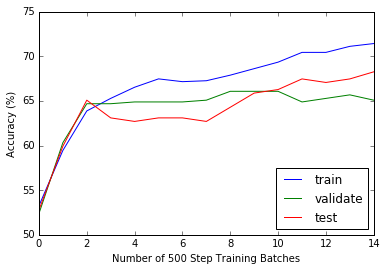

In [36]:
plt.plot(step_train_accuracy, label = 'train')
plt.plot(step_valid_accuracy, label = 'validate')
plt.plot(step_test_accuracy, label = 'test')
plt.ylabel('Accuracy (%)')
plt.xlabel('Number of 500 Step Training Batches')
plt.legend(loc=4)

# Trading Simulation

The model's performance will now be compared to two benchmark trading strategies, over the 252 day test set (10/01/2015 - 09/29/2016):

1. Buy and hold - the index is purchased at the opening price on the first day of the test period and then sold at the closing price of the last day of the test period.

2. Buy only - since always buying has a slight (52-54%) accuracy advantage over selling, the index is bought each day at the opening price and then sold at the closing price. This strategy is repeated each day, in contrast to the 'buy and hold' approach, which involves a single buy and a single sell event.

The model itself is evaluated as follows: if the model predicts the price will close higher, then the index is bought at the open and sold at the close. If the model predicts the price will close lower, then the index is sold at the open and bought at the close.

In [37]:
# Identify and format data needed for trading profit calculations

validated_data_limited = pd.DataFrame(validated_data.loc[:,'Date':'SP_Close'])
validated_data_limited = validated_data_limited[0:252]

# Read in the NN Model predictions:
ML_trading_data = pd.read_csv("eval-NN.csv",header=None)

# If column 1 > column 0, then the label (prediction) is '1' (i.e. S&P500 is predicted to increase that day)
ML_trading_data['Predicted_Up'] = ML_trading_data[0] + ML_trading_data[1]

ML_trading_data.loc[ML_trading_data[1]>0.5,'Predicted_Up'] = 1
ML_trading_data.loc[ML_trading_data[1]<=0.5,'Predicted_Up'] = 0

# Append the model predictions to the market data:

validated_data_limited['Predicted_Up'] = ML_trading_data['Predicted_Up']

# Reverse the dataframe order, so dates go from oldest to newest:
validated_data_limited = validated_data_limited.iloc[::-1]

# Buy and hold benchmark calculation:

validated_data_limited['Cum_Buy_Hold_Profit'] = validated_data_limited['SP_Close'] - (
    validated_data_limited['SP_Open'][251])

# Buy only benchmark calculation:

validated_data_limited['Buy_Only_Profit'] = validated_data_limited['SP_Close'] - validated_data_limited['SP_Open']
validated_data_limited['Cum_Buy_Only_Profit'] = np.cumsum(validated_data_limited['Buy_Only_Profit'])

# NN model results:
# Model profit is equal to the buy only profit, adjusted with a negative sign if the event is a sell instead:

validated_data_limited['Model_Profit'] = validated_data_limited['Buy_Only_Profit'] * (
    2*validated_data_limited['Predicted_Up'] -1)

validated_data_limited['Cum_Model_Profit'] = np.cumsum(validated_data_limited['Model_Profit'])

# Output the final cumulative profit for the ML strategy and the benchmarks:

print "Cumulative Buy and Hold Strategy Profit ($):", validated_data_limited['Cum_Buy_Hold_Profit'][0]
print "Cumulative Buy Only Strategy Profit ($):", validated_data_limited['Cum_Buy_Only_Profit'][0]
print "Cumulative Machine Learning Strategy Profit ($):", validated_data_limited['Cum_Model_Profit'][0]

Cumulative Buy and Hold Strategy Profit ($): 231.48
Cumulative Buy Only Strategy Profit ($): 234.98
Cumulative Machine Learning Strategy Profit ($): 1793.4


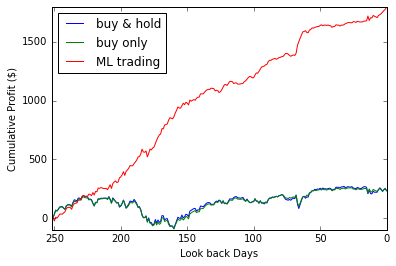

In [38]:
# Plot the cumulative performance of the ML trading strategy compared to the benchmarks:

trading_data = validated_data_limited

plt.axis([252,0,-100,1800])

plt.plot(trading_data['Cum_Buy_Hold_Profit'], label = 'buy & hold')
plt.plot(trading_data['Cum_Buy_Only_Profit'], label = 'buy only')
plt.plot(trading_data['Cum_Model_Profit'], label = 'ML trading')

plt.ylabel('Cumulative Profit ($)')
plt.xlabel('Look back Days')
plt.legend(loc=2)

In [39]:
print "Buy Only Daily Profit Summary Statistics:"
display(validated_data_limited['Buy_Only_Profit'].describe())
print '\n'
print "ML Trading Daily Profit Summary Statistics:"
display(validated_data_limited['Model_Profit'].describe())

Buy Only Daily Profit Summary Statistics:


count    252.000000
mean       0.932460
std       16.449823
min      -66.400000
25%       -7.320000
50%        0.810000
75%        9.092500
max       46.240000
Name: Buy_Only_Profit, dtype: float64



ML Trading Daily Profit Summary Statistics:


count    252.000000
mean       7.116667
std       14.853313
min      -50.060000
25%       -1.880000
50%        5.175000
75%       17.052500
max       66.400000
Name: Model_Profit, dtype: float64